# Using Q-learning on a classic control problem

This notebook will walk you through using Q-learning on a "classic control" problem; cart-pole

"The task is to balance a pole that is hinged to a movable cart by applying forces to the cart's base." - [Sutton, Barto et. al](https://ieeexplore.ieee.org/document/6313077) as implemented by Gymnasium.

There are 4 observations: 
1. The cart position 
2. The cart velocity
3. The pole angle
4. The pole angular velocity

There are two actions: 
1. Move the cart left (0)
2. Move the cart right (1)

There are three ways the task is terminated.
1. If the cart moves out of the area of play (±2.4 range)
2. If the angle of the pole is greater than ±12 degrees (±0.2095 radian)
3. The pole remains upright for more than 500 steps and the task is truncated

Q-learning can be applied to finite state Markov decision processes, in this example the observations are continuous, however they can be binned and made discrete as needed.

In [1]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np 
import random
import gym
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# %matplotlib inline
# %matplotlib notebook

warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

## One trial

First let's run through one trial of cartpole. 

The observation space has upper and lower limits for the four observations. For the cart position and pole angle they are double what the termination criterium would be. The cart velocity and pole angular velocity have no limits.

In [3]:
env = gym.make('CartPole-v1')
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


On reset of the environment, the four observations are set to values in the ±0.05 range.

In [4]:
observation, info = env.reset()
print(observation)

[ 0.0257025   0.037243   -0.01030125  0.04909259]


The environment is then evolved step-wise, with one action taken at each step.

In [5]:
# Set up for loop
terminated = False
truncated = False
score = 0

# Make environment
env = gym.make('CartPole-v1') #,render_mode="human") # Note you can visualise if you import pygame too
observation, info = env.reset()

# Plot the results of one game
cart_pos = []
pole_ang = []
# Run for one game
while terminated is False and truncated is False:

    action = env.action_space.sample()  # Pick either left(0) or right(1)
    observation, reward, terminated, truncated, info = env.step(action)
    
    cart_pos.append(observation[0])
    pole_ang.append(observation[2])
    score+=reward

env.close()
print(f"The score is {int(score)}")

if terminated:
    print("The game ended due to one of the two failure conditions being met")
elif truncated:
    print("The game ended after too many steps")
else:
    print("The game stopped for some unknown reason")

The score is 23
The game ended due to one of the two failure conditions being met


Importing pygame will allow the task to be visualised, however for this example where there are two failure conditions, a plot of the cart position and pole angle can show the process. 

In [6]:
def show_result(cart_pos, pole_ang):
    fig, ax = plt.subplots()
    ax.set_xlim([-3, 3])
    ax.set_ylim([-0.3, 0.3])
    
    xylim=[2.4,0.2095]
    ax.vlines(x=xylim[0], ymin=-xylim[1], ymax=xylim[1], linewidth=1, color="r")
    ax.vlines(x=-xylim[0], ymin=-xylim[1], ymax=xylim[1], linewidth=1, color="r")
    ax.hlines(y=xylim[1], xmin=-xylim[0], xmax=xylim[0], linewidth=1, color='r')
    ax.hlines(y=-xylim[1], xmin=-xylim[0], xmax=xylim[0], linewidth=1, color='r')

    ax.set_xlabel("Cart position")
    ax.set_ylabel("Pole Angle (radians)")

    ax.scatter(cart_pos,pole_ang, marker="x",color="k")
    plt.show()

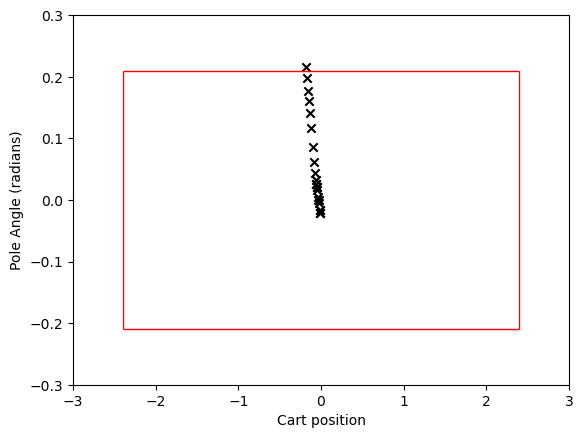

In [7]:
show_result(cart_pos,pole_ang)

In the overwhelming majority of cases, the termination is due to the pole angle exceeding the allowed limits - which graphically would result in a series of points exiting the red rectangle at the top or bottom

## Running multiple games

In order to see the range of results from an unoptimised process, lets run multiple experiments and see the state when it terminates

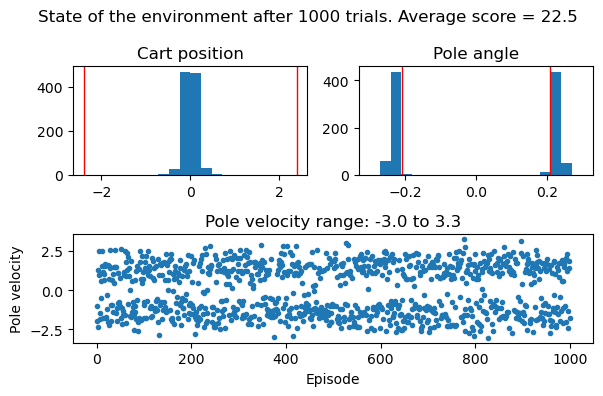

In [8]:
n_exp = 1000
score = 0

cpos = []
pang = []
pvel = []
score = 0

for exp in range(n_exp):
    # Set up for loop
    terminated = False
    truncated = False


    # Reset environment
    env = gym.make('CartPole-v1')
    observation, info = env.reset()

    while terminated is False and truncated is False:

        action = env.action_space.sample()
        observation, reward, terminated, truncated, info = env.step(action)
        score+=reward
        
    cpos.append(observation[0])
    pang.append(observation[2])
    pvel.append(observation[3])

    env.close()

x = list(range(n_exp))
fig, axs = plt.subplots(2, 2, figsize=(6, 4))
fig.suptitle(f"State of the environment after {n_exp} trials. Average score = {(score/n_exp):.1f}")

axs0 = plt.subplot(221)
axs0.hist(cpos, bins=20,range=(-2.4,2.4))
axs0.set_title("Cart position")
axs0.axvline(x=2.4, linewidth=1, color="r")
axs0.axvline(x=-2.4, linewidth=1, color="r")

axs1 = plt.subplot(222)
axs1.hist(pang,bins=20,range=(-0.3,0.3))
axs1.set_title("Pole angle")
axs1.axvline(x=0.2095, linewidth=1, color="r")
axs1.axvline(x=-0.2095, linewidth=1, color="r")


axs2 = plt.subplot(212)
axs2.set_title(f"Pole velocity range: {min(pvel):.1f} to {max(pvel):.1f}")
axs2.scatter(x, pvel, marker=".")
axs2.set_ylabel("Pole velocity")
axs2.set_xlabel("Episode")
fig.tight_layout()

plt.show()

After 1,000 trials it is confirmed that the termination cause for an untrained system is the pole angle exceeding the allowed limits.

## Setting up the table

First the continuous observations (cart position and velocity, and pole angle and anglular velocity) are binned to allow them to be used.

In [9]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In this example only two features will be used for optimisation. The pole angle - which is the leading cause of experiment termination, and it's angular velocity. The angle data will be binned into 10 and the velocity into 10.

In [10]:
n_bins = (10, 10)

# Set the upper and lower bounds for the velocity based on the observations of the velocity (±20%)
pv = max(abs(min(pvel)), abs(max(pvel)))*1.2
lower_bounds = [env.observation_space.low[2], -pv]
upper_bounds = [env.observation_space.high[2], pv]

def discretizer( _ , __ , angle, pole_velocity ):
    """
    Convert continues state into a discrete state
    
    From the environment state space, creates equal bins spaning ± pole 
    angle(+50) radian range
    
    Argument: 
        4 observations
    Return:
        indicies of the bin that the (pole) data would have been placed into
    
    """
    estimator = KBinsDiscretizer(n_bins = n_bins,
                                 encode='ordinal',
                                 strategy='uniform')
    
    estimator.fit([lower_bounds, upper_bounds ])
    return tuple(map(int,estimator.transform([[angle, pole_velocity]])[0]))

Next a table is generated that holds the Q values, with space for each (discrete) state and action combination. After optimisation the values in the table give the expected reward if a particular action is taken while the environment is in that particular state. The table is initalised with zeros, however it doesn't need to be. Purely exploitative functions can be initialised with non-zero values and depending on the type of problem that is being investigated, they can improve overall results as seen with the multi-armed bandit example.

In [11]:
Q_table = np.zeros(n_bins + (env.action_space.n,))
Q_table.shape

(10, 10, 2)

Next a policy is decided. In this case it is the epsilon-greedy policy which will always pick the action that will maximise results. There is no room for exploration with the epsilon-greedy policy so if the initial conditions are such that what is overall a sub-optimal move is the most optimal at that step; the optimisation may not converge to a truly optimal solution.

In [12]:
def policy(state):
    """
    Choosing action based on epsilon-greedy policy - always pick 
    the highest scoring option
    
    Argument:
        indecies of the bin that the (pole) data are in
    
    Return
        Index of the cell containing the highest number 
        (or the first instance of the number when ties occur )
    """
    return np.argmax(Q_table[state])

The Q value needs to be updated as the environment is evolved. Here the reward, and current value of the Q-table in the specific state are used to update the prediction.

In [13]:
def new_Q_value(reward, new_state, discount_factor=1 ):
    """
    Temperal diffrence for updating Q-value of state-action pair
    
    Argument:
        Reward for the step
        The indicies of the pole data in the Q-table
        The discount factor (0 means only consider the immediate reward
            1 means fully consider the future optimal rewards)
    
    Return:
        Updated value for the Q-table in the new_state
    
    """
    
    future_optimal_value = np.max(Q_table[new_state])
    
    learned_value = reward + discount_factor * future_optimal_value
    
    return learned_value

The learning rate defines how heavily you want to weight particular parts of the optimisation. Ususally the earlier runs are weighted more heavily, so we can learn quicker, before decaying and learning less at the end.

In [14]:
# Adaptive learning of Learning Rate
def learning_rate(n, min_rate=0.01 ):
    """
    Decaying learning rate
    Will return 1 for the first 25 points then decay to 0.01
    Ensures that the earlier trials contribute more heavily
    to the learning
    
    Argument:
        Step of the optimisation
        The minimum rate of learning
        
    Return:
        Number between 1 and 0.01
    """
    return max(min_rate, min(1.0, 1.0 - np.log10((n + 1) / 25)))

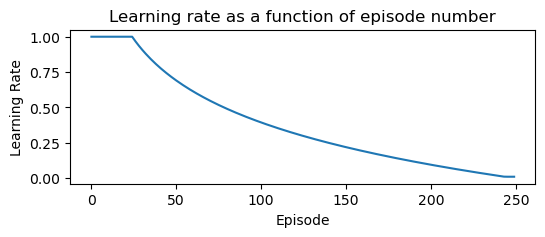

In [15]:
example_nepisodes=250
fig = plt.figure(figsize=(6, 2))
plt.plot(list(range(example_nepisodes)),list(map(learning_rate, list(range(example_nepisodes)))))
plt.xlabel("Episode")
plt.ylabel("Learning Rate")
plt.title("Learning rate as a function of episode number")
plt.show()

In [16]:
def exploration_rate(e, min_rate = 0.1 ):
    """
    Decaying exploration rate
    Will return 1 for the first 25 points then decay to 0.1 and
    ensure no exploration for the first 25 episodes.
    
    Argument:
        Step of the optimisation
        The minimum rate of learning
        
    Return:
        Number between 1 and 0.1
        
    """
    return max(min_rate, min(1.0, 1.0 - np.log10((e  + 1) / 25)))

## Running the trials

Now we run through the trials updating the q-tables for each episode

In [17]:
n_episodes = 1000
print_freq = 100
score_card = []
for e in range(n_episodes):
    score = 0
    
    # Discretize state into buckets
    initial_observation, info = env.reset()
    current_state = discretizer(*initial_observation)
        
    terminated = False; truncated = False
    
    track_score = True if e%print_freq == 0 else False
    
    
    while terminated is False and truncated is False:
        
        # policy action 
        action = policy(current_state) # Apply the epsilon-greedy policy
        
        # insert random action
        if np.random.random() < exploration_rate(e): # exploration rate = 1 for first 25 episodes
            action = env.action_space.sample() # sample from the environment action space (0 or 1) 
         
        # increment enviroment
        obs, reward, terminated, truncated, info = env.step(action)
        new_state = discretizer(*obs)
        
        # Update Q-Table
        lr = learning_rate(e)
        learnt_value = new_Q_value(reward, new_state)
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value
        
        current_state = new_state
        score += reward
            
    score_card.append(score)
    if track_score:
        print(f"At end of episode {e}, Score = {int(score)}")
        

At end of episode 0, Score = 20
At end of episode 100, Score = 65
At end of episode 200, Score = 187
At end of episode 300, Score = 146
At end of episode 400, Score = 145
At end of episode 500, Score = 146
At end of episode 600, Score = 209
At end of episode 700, Score = 105
At end of episode 800, Score = 211
At end of episode 900, Score = 206


## Looking at the results

As there are only two actions in this example the Q tables can be visualised as heatmaps for each action. The heatmaps show the expected reward from the environment in that state (with pole angle and velocity as specified) if the action was taken. 

In [18]:
left_qtable = Q_table[:,:,0]
right_qtable = Q_table[:,:,1]

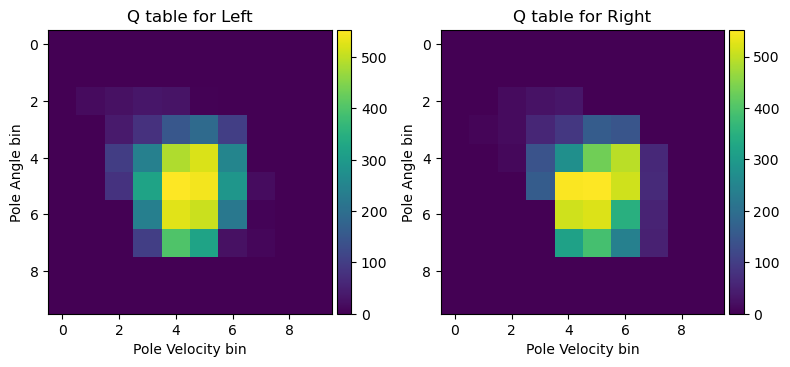

In [19]:
action_map={0: "Left", 1:"Right"}
fig, ax = plt.subplots(1,2, figsize=(8,4))
im = ax[0].imshow(left_qtable)
im_r = ax[1].imshow(right_qtable)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)

divider = make_axes_locatable(ax[1])
cax_r = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.colorbar(im_r, cax=cax_r)

for lr in [0,1]:
    ax[lr].set_title(f"Q table for {action_map[lr]}")
    ax[lr].set_ylabel("Pole Angle bin")
    ax[lr].set_xlabel("Pole Velocity bin")


fig.tight_layout()
plt.show()

And if we look at the scores after each episode we should see an improvement in the score with increasing episode number. This corresponds to creating an optimal policy. 

If the optimal policy is found, then the score for later episodes should be 500, corresponding to a truncation-end of the simulation rather than a failure condition being met.

If it appears that the system is stabilising around a value lower than 500, this indicates that the state space was not explored fully, and changes in the learning rate, or exploration rate would affect this. 

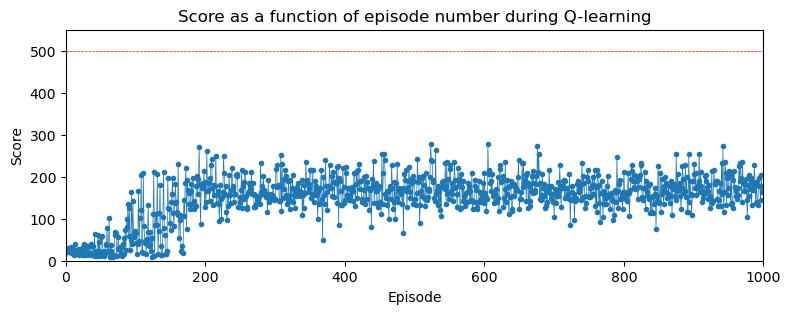

In [20]:
fig = plt.figure(figsize=(9, 3))
plt.plot(list(range(n_episodes)),score_card,marker='.',linewidth=0.5)
plt.xlim([0,n_episodes])
plt.ylim([0,550])
plt.hlines(500, 0, n_episodes, colors='r', ls='dashed', lw=0.5)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("Score as a function of episode number during Q-learning")
plt.show()